In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from bcnf.simulation.physics import get_data
from bcnf.models.cnf import CondRealNVP
from bcnf.models.feature_network import FullyConnectedFeatureNetwork
from bcnf.train.train import train_CondRealNVP
from bcnf.eval.crossvalidate import cross_validate
from bcnf.utils import partconv1d, get_gaussian_kernel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
X, y = get_data(
    T=5.0,
    dt=0.1,
    N=10_000,
    break_on_impact=False
)

X_tensor = torch.Tensor(X.reshape(X.shape[0], -1))
y_tensor = torch.Tensor(y)

print(f'{X_tensor.shape=}, {y_tensor.shape=}')

100%|██████████| 10000/10000 [00:13<00:00, 714.38it/s]

X_tensor.shape=torch.Size([10000, 150]), y_tensor.shape=torch.Size([10000, 17])


In [3]:
condition_size = 1024

model_kwargs = {
    "size": y_tensor.shape[1],
    "hidden_size": 64,
    "n_blocks": 32,
    "n_conditions": condition_size,
    "act_norm": True,
}

feature_network_kwargs = {
    "sizes": [X_tensor.shape[1]] + [1024] * 5 + [condition_size],
    "dropout": 0.5,
}

optimizer_kwargs = {
    "lr": 1e-3
}

lr_scheduler_kwargs = {
    "mode": "min",
    "factor": 0.5,
    "patience": 50,
}

In [4]:
results = cross_validate(
    model_class=CondRealNVP,
    model_kwargs=model_kwargs,
    feature_network_class=FullyConnectedFeatureNetwork,
    feature_network_kwargs=feature_network_kwargs,
    optimizer_class=torch.optim.Adam,
    optimizer_kwargs=optimizer_kwargs,
    lr_scheduler_class=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_kwargs=lr_scheduler_kwargs,
    X=X_tensor,
    y=y_tensor,
    n_epochs=10_000,
    val_loss_patience=200,
    val_loss_tolerance=1e-3,
    batch_size=256,
    device=device,
)

Train: -48.5339 - Val: -48.3120 | lr: 7.81e-06 - Val*: -48.7279 - Early Stopping Patience: 22/200:  12%|█▏        | 1214/10000 [15:55<2:00:00,  1.22it/s]        

In [ ]:
val_loss_mean = np.mean([r['val_loss'] for r in results])
val_loss_std = np.std([r['val_loss'] for r in results], ddof=1)

print(f'Validation loss: {val_loss_mean:.2f} ± {val_loss_std:.2f}')

Validation loss: -24.54 ± 1.01


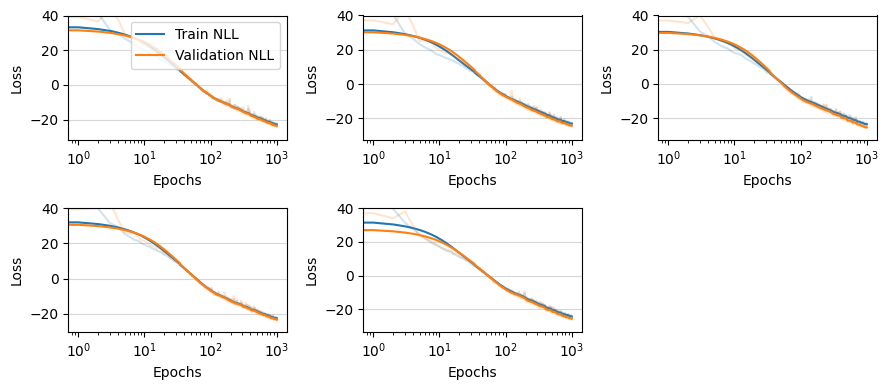

In [ ]:
COLS = 3
ROWS = np.ceil(len(results) / COLS).astype(int)

fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS * 3, ROWS * 2))

for r, ax in zip(results, axes.flatten()):
    ax.plot(r['loss_history']['train'], alpha=0.2, color='C0')
    ax.plot(partconv1d(np.array(r['loss_history']['train']), kernel=get_gaussian_kernel(sigma=10)), label='Train NLL', color='C0')

    ax.plot(r['loss_history']['val'], alpha=0.2, color='C1')
    ax.plot(partconv1d(np.array(r['loss_history']['val']), kernel=get_gaussian_kernel(sigma=10)), label='Validation NLL', color='C1')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')

    ax.set_xscale('log')
    ax.set_ylim(None, 40)
    ax.grid(axis='y', alpha=0.5)

axes[0, 0].legend();

for ax in axes.flatten()[len(results):]:
    ax.axis('off')

fig.tight_layout()